In [1]:
# https://download.pytorch.org/tutorial/data.zip
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string


#########################################################
all_letters = string.ascii_letters + " .,;'"  ## NO TOUCH! ONLY THROW!
n_letters = len(all_letters)
#########################################################



# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
#category_lines  { "all_categories[index]" : list_of_names}
# print(all_categories)
# print(category_lines[all_categories[0]])


# important stuff from this box is
# category_lines = dict with all stuff
# all_categories = list with all keys for category_lines
# n_categories = number of categories.
# n_letters = number of letters, or your input dimensions

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [99]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(n_letters)
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(n_letters)
    for letter in (line):
        tensor[all_letters.find(letter)] += 1
    return tensor.unsqueeze(0)

print(lineToTensor('Jones').size()) # 57

torch.Size([1, 57])


In [180]:
def randomTrainingExample(batch_size,n_categories):
    line_holder = torch.zeros(batch_size,1,57)
    cat_holder = torch.zeros(batch_size)
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        line = category_lines[category][random.randint(0, len(category_lines[category]) - 1)]
        line_holder[i] = lineToTensor(line)
        cat_holder[i]=all_categories.index(category) # indicate that this particular is the correct ans
#         category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
#         line_tensor = 
    return cat_holder,line_holder

# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     print('category =', category, '/ line =', line)

In [181]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)   # obtain the max value value, index
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [281]:
# word_embeddings = nn.Embedding(vocab_size, n_categories) # word embeddings appear to be useless
# linear_layer = nn.Linear(hidden_dim, tagset_size)# we then add a linear to it.. make it more sensible..?
class lstm_class(nn.Module):
    def __init__(self, n_letters, n_categories,hidden_number): 
        super(lstm_class, self).__init__()
        self.lstm = nn.LSTM(n_letters, hidden_number)  # Input dim is 3, output dim is number of hidden layers
        self.hidden2tag = nn.Linear(hidden_number, n_categories)
#         self.softmax = nn.Softmax(dim=1)
    def forward(self,states,name):        
        h_n,c_n = self.lstm(name,states)
        # h_n is the h output at each word ...
        # c_n is the outputs i want. 
#         print(h_n.shape) # torch.Size([6, 1, 57])
#         print(len(c_n))
#         print(c_n[0].shape)
#         print(c_n[1].shape)
        out1 = self.hidden2tag(h_n).float().squeeze(1)
#         out2 = self.softmax(out1).squeeze(1)
        out2 = out1
        return out2

In [295]:
no_hidden_layers = 10
a_lstm = lstm_class(n_letters, n_categories,no_hidden_layers)
loss_function = nn.CrossEntropyLoss()
batch_size =8
optimizer = optim.SGD(a_lstm.parameters(), lr=0.01)

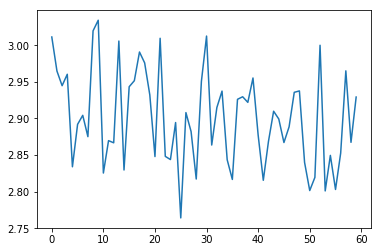

In [296]:
lossy = []
for i in range(60):
    category_tensor, line_tensor = randomTrainingExample(batch_size,n_categories)
    initial = torch.zeros(1,1, no_hidden_layers)
    hidden = torch.zeros(1, 1, no_hidden_layers)
    states = initial,hidden 
    output = a_lstm(states,line_tensor)  # torch.Size([6, 18])
    loss = loss_function(output, category_tensor.long())
    lossy.append(loss.item())
    loss.backward()
    optimizer.step()

plt.plot(lossy)
plt.show()